In [5]:
pip install nba_api pandas matplotlib

Note: you may need to restart the kernel to use updated packages.


Number of heavy-minute games: 64
Number of low/no-minute games: 18
For Boston Celtics in 2023-24:
- When Jayson Tatum plays 30+ minutes: average margin = 8.2 points per game.
- When Jayson Tatum plays <30 or 0 minutes: average margin = 22.4 points per game.


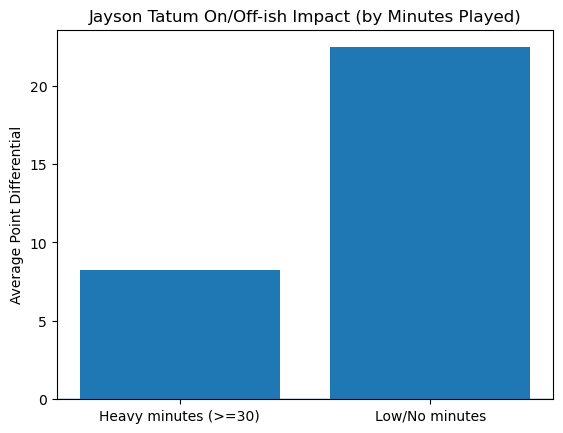

In [1]:
from nba_api.stats.static import teams, players
from nba_api.stats.endpoints import leaguegamefinder, boxscoretraditionalv3
import pandas as pd
import time
import matplotlib.pyplot as plt

# ------------------------------------------------
# 1. Find team and player (Boston Celtics / Tatum)
# ------------------------------------------------
all_teams = teams.get_teams()
celtics = [t for t in all_teams if t['full_name'] == 'Boston Celtics'][0]
team_id = celtics['id']

all_players = players.get_players()
tatum = [p for p in all_players if p['full_name'] == 'Jayson Tatum'][0]
player_id = tatum['id']

player_name = tatum['full_name']
team_name = celtics['full_name']

# ------------------------------------------------
# 2. Get Celtics games for 2023-24 Regular Season
# ------------------------------------------------
gamefinder = leaguegamefinder.LeagueGameFinder(
    team_id_nullable=team_id,
    season_nullable='2023-24',
    season_type_nullable='Regular Season'
)

games_df = gamefinder.get_data_frames()[0]

# list of game IDs
sample_games = games_df['GAME_ID'].unique()

# ------------------------------------------------
# 3. Loop through games, get box scores via V3
# ------------------------------------------------
records = []

for game_id in sample_games:
    # be nice to the API
    time.sleep(0.6)

    # call NBA stats BoxScoreTraditionalV3 via nba_api
    box = boxscoretraditionalv3.BoxScoreTraditionalV3(game_id=game_id)

    # work with the raw dict so we control the structure explicitly
    raw = box.get_dict()

    # home/away team info + player lists
    box_trad = raw['boxScoreTraditional']
    home_team = box_trad['homeTeam']
    away_team = box_trad['awayTeam']

    home_team_id = int(home_team['teamId'])
    away_team_id = int(away_team['teamId'])

    # flatten players via pandas.json_normalize
    home_players = pd.json_normalize(home_team['players'])
    away_players = pd.json_normalize(away_team['players'])

    # points for each team
    # statistics.points is numeric in the JSON; cast just in case
    home_points = pd.to_numeric(
        home_players['statistics.points'], errors='coerce'
    ).fillna(0).astype(int).sum()

    away_points = pd.to_numeric(
        away_players['statistics.points'], errors='coerce'
    ).fillna(0).astype(int).sum()

    # choose which side is "our" team
    if team_id == home_team_id:
        team_points = home_points
        opp_points = away_points
        # Tatum row from the combined players
        all_players_df = pd.concat([home_players, away_players], ignore_index=True)
    elif team_id == away_team_id:
        team_points = away_points
        opp_points = home_points
        all_players_df = pd.concat([home_players, away_players], ignore_index=True)
    else:
        # shouldn't happen for Celtics games, but just in case
        continue

    margin = team_points - opp_points

    # ------------------------------------------------
    # Tatum minutes
    # ------------------------------------------------
    # personId in JSON corresponds to player_id from nba_api
    player_row = all_players_df[all_players_df['personId'] == player_id]

    if len(player_row) > 0:
        min_str = player_row.iloc[0]['statistics.minutes']
        if isinstance(min_str, str) and ':' in min_str:
            mins = int(min_str.split(':')[0])
        else:
            mins = 0
    else:
        mins = 0  # DNP

    records.append({
        'GAME_ID': game_id,
        'TEAM_POINTS': team_points,
        'OPP_POINTS': opp_points,
        'MARGIN': margin,
        'PLAYER_MINUTES': mins
    })

impact_df = pd.DataFrame(records)

# ------------------------------------------------
# 4. “On/Off-ish” split by minutes
# ------------------------------------------------
impact_df['HEAVY_MINUTES'] = impact_df['PLAYER_MINUTES'] >= 30

on_df = impact_df[impact_df['HEAVY_MINUTES']]
off_df = impact_df[~impact_df['HEAVY_MINUTES']]

print("Number of heavy-minute games:", len(on_df))
print("Number of low/no-minute games:", len(off_df))

on_margin = on_df['MARGIN'].mean()
off_margin = off_df['MARGIN'].mean()

print(f"For {team_name} in 2023-24:")
print(f"- When {player_name} plays 30+ minutes: average margin = {on_margin:.1f} points per game.")
print(f"- When {player_name} plays <30 or 0 minutes: average margin = {off_margin:.1f} points per game.")

# ------------------------------------------------
# 5. Simple bar chart
# ------------------------------------------------
labels = ['Heavy minutes (>=30)', 'Low/No minutes']
margins = [on_margin, off_margin]

plt.bar(labels, margins)
plt.ylabel('Average Point Differential')
plt.title(f'{player_name} On/Off-ish Impact (by Minutes Played)')
plt.axhline(0, linewidth=1)
plt.show()
